The goal of this notebook is to implement a simple 1D wave propagation simulation, as explained by Hans-Petter Langtangen in his class [INF5620](https://github.com/hplgit/INF5620) and more precisely in [this PDF](hplgit.github.io/INF5620/doc/pub/main_wave.pdf). The problem to be solved is that of a wave propagating on a string, just like in the case of a guitar.

In this notebook, we will use the simulation code writte by Mr Langtangen for the case of a (transversely) vibrating string and perform extractions of the simulated date so as to visualize it. In this process, we will use Matplotlib to embed animations and perform a little bit of Fourier analysis.

First, let's simulate the string!

# Simulation 

Below, I've adapted the code of Mr Langtangen (from the above cited PDF).

In [1]:
from numpy import linspace, zeros

def solver(I, V, f, c, L, Nx, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    x = linspace(0, L, Nx+1) # Mesh points in space
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Mesh points in time
    C2 = C**2 # Help variable in the scheme
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solution array at new time level
    u_1 = zeros(Nx+1) # Solution at 1 time level back
    u_2 = zeros(Nx+1) # Solution at 2 time levels back
    
    import time; t0 = time.clock() # for measuring CPU time
    
    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])
    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Switch variables before next step
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
            C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
            dt**2*f(x[i], t[n])
        # Insert boundary conditions
        u[0] = 0; u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break
        # Switch variables before next step
        u_2[:], u_1[:] = u_1, u
    cpu_time = t0 - time.clock()
    return u, x, t, cpu_time

The code calls a user defined routined at each simulation step.

We can use that mechanism and define a user action routine that will store the simulation snapshots, so that we can perform some later analysis.

In [2]:
def user_action(u, x, t, n):
    "Defines a user action that stores the current simulated state for further usage."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

Let's now run a simulation using initial conditions of a 1 meter long string in the shape of a quadratic function, for a duration of 1 second and a speed of sound of 100 m/s. At each time step, we keep the simulation state for later use.

In [3]:
user_data = {}
u, x, t, cpu_time = solver(lambda x: x*(1-x), None, None, 100, 1, 100, 0.1, 1., user_action=user_action)

# Visualization of the data

Now that we have gathered our date, let's start visualizing it. We can plot the final position of the string computed by the program:

In [4]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [5]:
%matplotlib inline

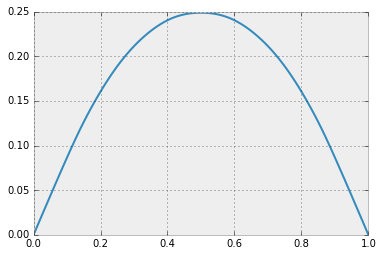

In [6]:
plt.plot(x, u)

Let's examine the different simulation solution steps using a widget browser:

In [7]:
from ipywidgets import interact

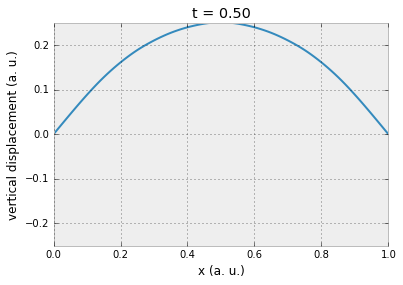

In [8]:
@interact
def browse_simulation_result(n=(0, len(user_data['u']) - 1)):
    "Plots a frame of the simulation."
    x = user_data['x']
    t, u = user_data['u'][n]
    plt.plot(x, u)
    plt.title('t = {:.2f}'.format(t))
    plt.ylim(-0.25, 0.25)
    plt.xlabel('x (a. u.)')
    plt.ylabel('vertical displacement (a. u.)')

We see the string oscillating and keeping its initial bell shape. On the edges of the string, the zero displacement boundary condition keeps it fixed.

# Animation of the data 

Let's now make a moviepy animation using this data. We can embed it directly in this notebook using the `ipython_display` function. 

In [9]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

duration = 30

fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=150)
plt.tight_layout()
def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u)
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-0.25, 0.25)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('vertical displacement (a. u.)')
    return mplfig_to_npimage(fig) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=25, width=800)

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '

100%|███████████████████████████████████████▉| 750/751 [00:51<00:00, 14.91it/s]


# Looking at the spectrum of the data 

We can also build a matrix with some snapshots of the numerical solution. 

In [10]:
import numpy as np

In [11]:
mat = np.array([b for a,b in user_data['u'][::20]])

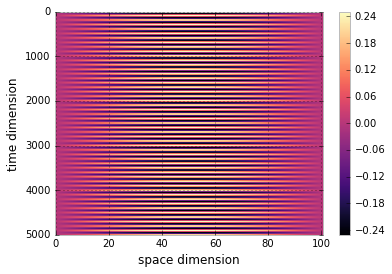

In [12]:
plt.imshow(mat, aspect='auto', cmap='magma')
plt.xlabel('space dimension')
plt.ylabel('time dimension')
plt.colorbar()

As we can see on the above plot, we see the oscillations along the time dimension, as well as an amplitude that depends on the node location along the string (maximum in the center, zero on the edges).

We can examine individual profiles of movement along the time dimension by performing vertical cuts in the above data:

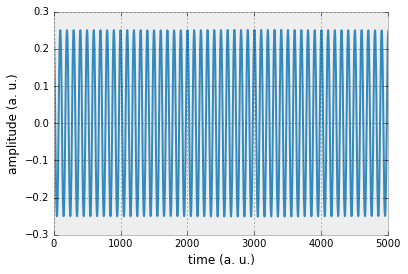

In [13]:
@interact 
def space_cut(n=(0, mat.shape[1] - 1)):
    "Plots time profile at fixed position."
    plt.plot(mat[:, n])
    plt.xlabel('time (a. u.)')
    plt.ylabel('amplitude (a. u.)')

We can display these oscillations in time at different positions:

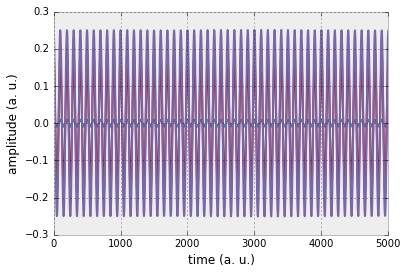

In [14]:
space_cut(1)
space_cut(25)
space_cut(49)

What we see here is that depending on the observation location, the vibration profile looks similar, except for the amplitude: the edges of the string vibrate less than the middle of the string.

We can also perform a Fourier analysis of each slice:

In [15]:
dt = 20 * user_data['u'][1][0] - user_data['u'][0][0]

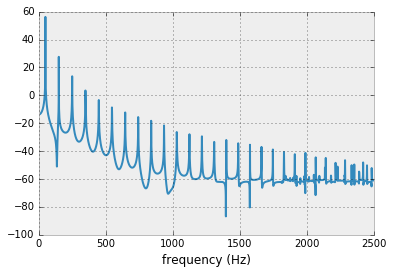

In [16]:
@interact 
def space_cut_frequency(n=(0, mat.shape[1] - 1)):
    "Plots time profile at fixed position."
    sig = mat[:, n]
    X = np.fft.rfft(sig)
    freqs = np.fft.rfftfreq(sig.size, d=dt)
    plt.plot(freqs, 20 * np.log10(np.abs(X)))
    plt.xlabel('frequency (Hz)')

We can superimpose a few cuts on the same graph:

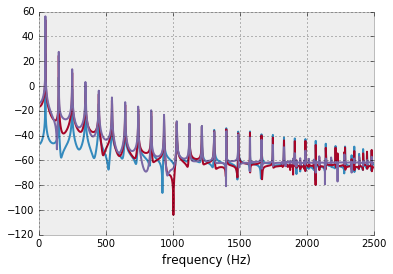

In [17]:
space_cut_frequency(1)
space_cut_frequency(25)
space_cut_frequency(49)

An interesting conclusion from this Fourier analysis is that each individual time signal is composed of a number of discrete harmonics. This is an expected result, as a vibrating string only allows frequencies that are multiples of a frequency 

$$
f = \frac{v}{2L} 
$$

In our case, this frequency should be:

In [18]:
100 / (2 * 1)

50.0

(0, 300)

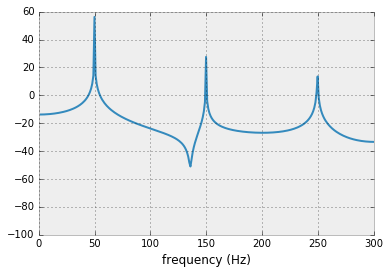

In [19]:
space_cut_frequency(49)
plt.xlim(0, 300)

By looking at the above plot, we can see that the fundamental frequency is indeed 50 Hz, but that the following frequencies all seem to be odd multiples of the fundamental frequency. I believe this is a consequence of the fixed conditions that are imposed at the boundaries of the string and that "force" even multiples of the fundamental to be zero. 

# Conclusions 

In this notebook, we have used a simple 1 dimensional finite difference simulation of the wave equation. This has allowed us to do several things: animating the solution, examining its variations in space and also frequency domain. In particular, it is interesting to see that even multiples of the fundamental vibrating frequency of the string were not observed.